# Týdenní vytíženost stanic

In [152]:
import datetime
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
import statsmodels.api as sm
import tsplot as ts

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [2]:
username = os.environ["POSTGRES_USER"]
password = os.environ["POSTGRES_PASSWORD"]
conn_string = f"postgresql+psycopg2://{username}:{password}@{os.environ['POSTGRES_HOST']}/{os.environ['POSTGRES_DB']}"
db = create_engine(conn_string)
conn = db.connect()

## Příprava dat
Pro seznámení s daty zvolíme pražskou stanici 3102, která kontroluje osobní automobily.

Data jsou získána z již předpřipravané databáze jednotlivých prohlídek na STK.
Databáze byla vytvořena vyčistěním dat získaných od Ministerstva dopravy ČR a pokrývá roky 2018--2022.

In [233]:
records = conn.execute(
  text(
      f"""SELECT station_id, date, count(*)
FROM inspections
WHERE station_id = '3102'
GROUP BY station_id, date"""
  )
).all()

records = np.array(records)

data = pd.DataFrame({
  "station_id": records[:, 0].flatten(),
  "date": records[:, 1].flatten(),
  "inspections": records[:, 2].flatten(),
})

data['date'] = data['date'].astype('datetime64[ns]')
data.to_csv('data.csv')

In [237]:
data = pd.read_csv('data.csv', index_col=0)
data['date'] = data['date'].astype('datetime64[ns]')
data

,station_id,date,inspections
0,3102,2018-01-02,47
1,3102,2018-01-03,37
2,3102,2018-01-04,56
3,3102,2018-01-05,13
4,3102,2018-01-08,55
...,...,...,...
1216,3102,2022-11-24,51
1217,3102,2022-11-25,20
1218,3102,2022-11-28,48
1219,3102,2022-11-29,43


In [238]:
# set index to the date and fill missing days with 0
timeseries = data[['date', 'inspections']]
# add 2018-01-01 if missing
if timeseries[timeseries['date'] == '2018-01-01'].shape[0] == 0:
  timeseries.iloc[-1] = ['2018-01-01', 0]
timeseries = timeseries.set_index('date').asfreq('1D', fill_value=0)
timeseries

,inspections
date,
2018-01-01,0
2018-01-02,47
2018-01-03,37
2018-01-04,56
2018-01-05,13
...,...
2022-11-25,20
2022-11-26,0
2022-11-27,0


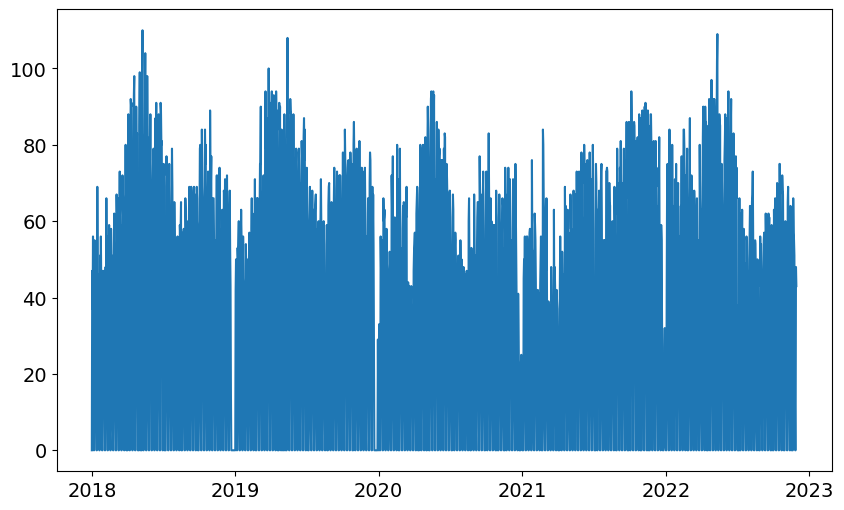

In [131]:
plt.plot(timeseries)

Časová řada nevykazuje trend.
Vidíme sezónnost na bázi pololetí, možná spíše celého roku, v létě totiž počet prohlídek klesá, na jaře a na podzim je vyšší.
Je znatelný velký rozptyl hodnot, který musíme analyzovat bližším pohledem.
Od druhé poloviny roku 2020 do první poloviny 2021 pozorujeme poněkud menší maxima než v jiných letech, interpretace pomocí Covidu je nasnadě, ale dává v případě automobilů smysl?

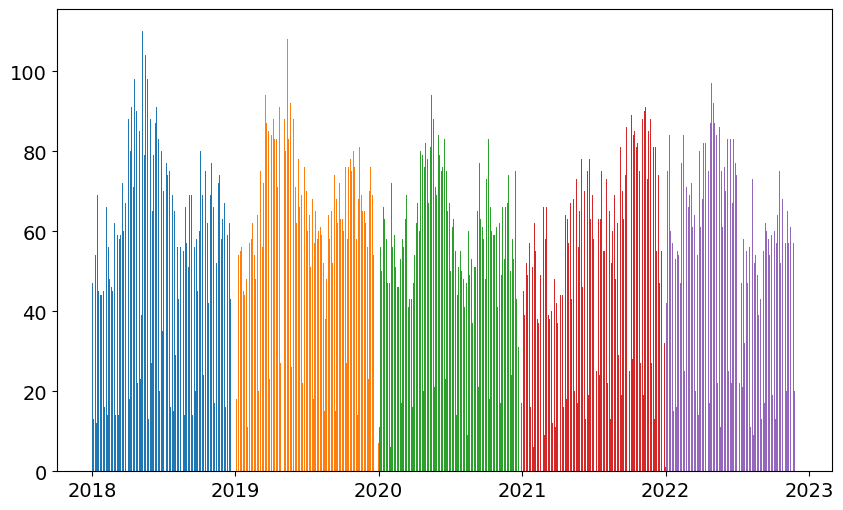

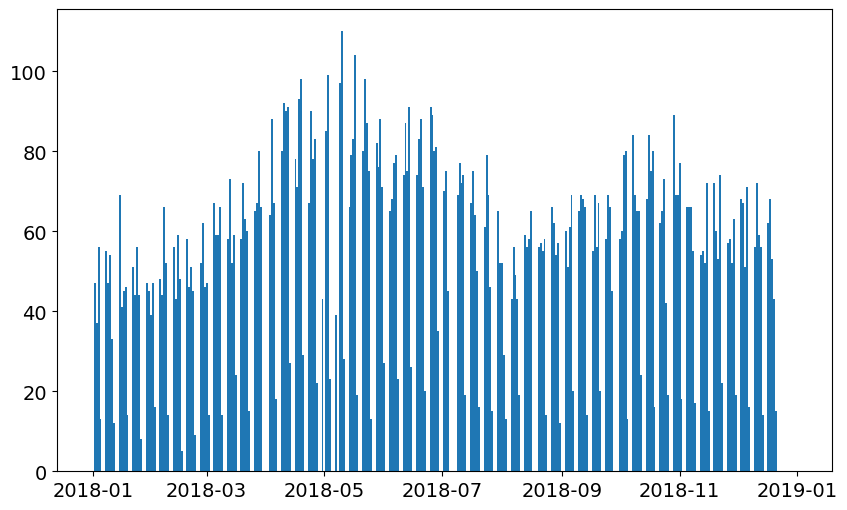

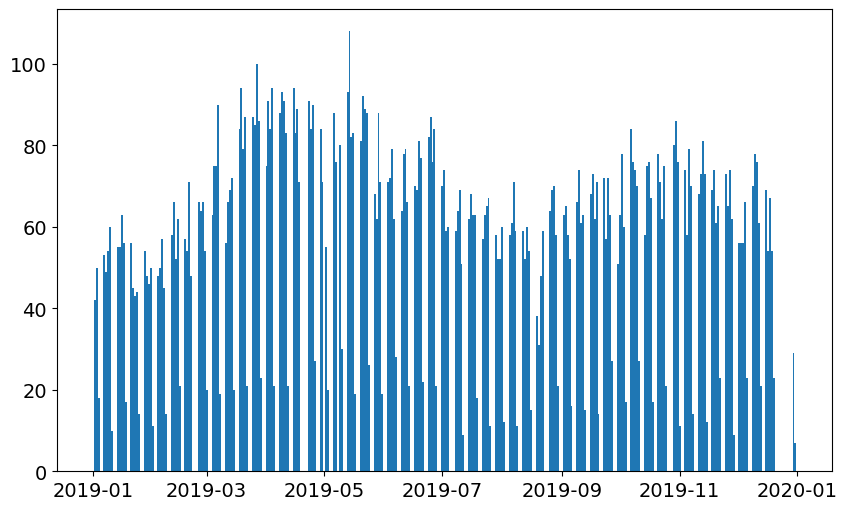

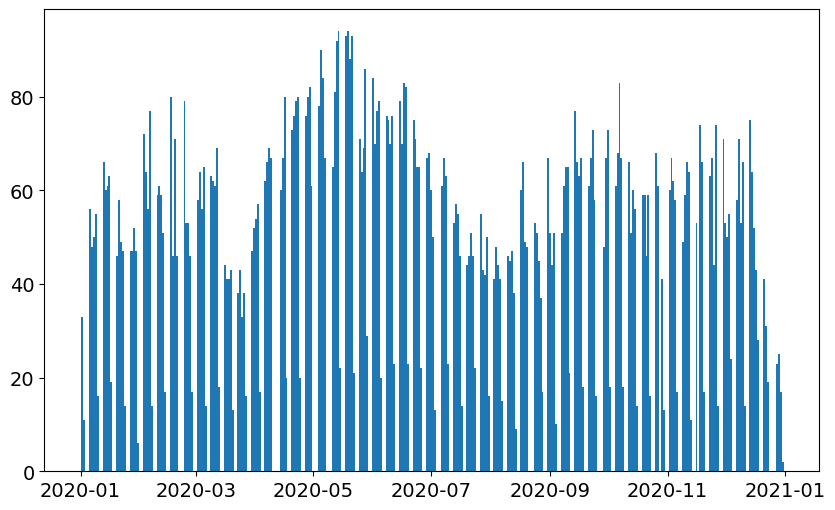

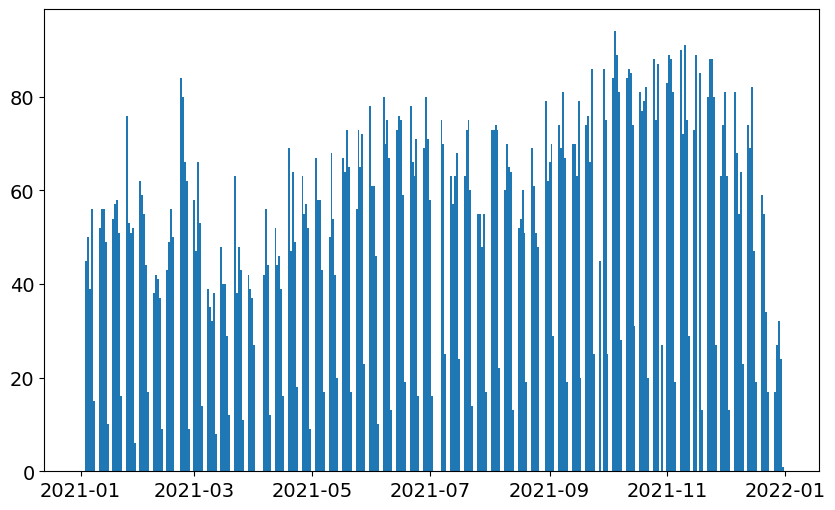

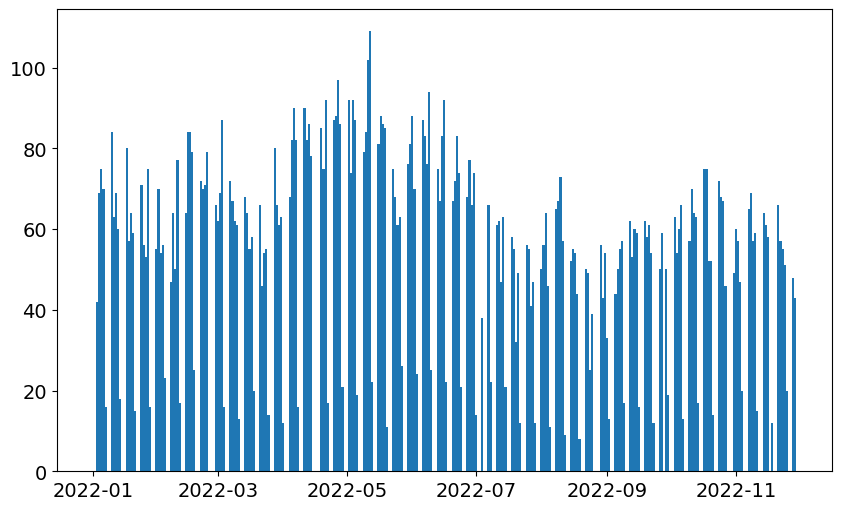

In [132]:
for year in range(2018, 2023):
  plt.bar(x=timeseries[f'{year}-01-01':f'{year}-12-31'].index, height=timeseries[f'{year}-01-01':f'{year}-12-31']['inspections'], width=1)
plt.show()

for year in range(2018, 2023):
  plt.bar(x=timeseries[f'{year}-01-01':f'{year}-12-31'].index, height=timeseries[f'{year}-01-01':f'{year}-12-31']['inspections'], width=1)
  plt.show()

Roky 2018 a 2019 vypadají velmi podobně.
V roce 2020 pozorujeme dubnový výrazný propad a celkově menší maximální počty prohlídek.
Nabízí se vysvětlení pomocí COVID-19.

Ke konci roku 2021 jako by se kompenzovalo předchozí snížení a rok 2022 vypadá opět podobně "normálu", tedy jako 2018 a 2019.

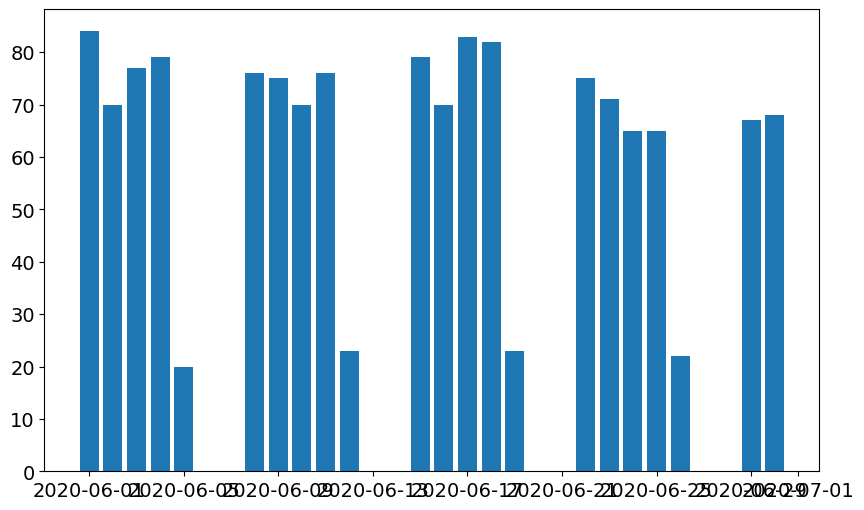

In [133]:
plt.bar(x=timeseries['2020-06-01':'2020-6-30'].index, height=timeseries['2020-06-01':'2020-6-30']['inspections'])
plt.show()

V zobrazení června 2020 jasně vidíme nízký počet prohlídek v pátek a nulu o víkendu. Sezónnost na úrovni týdne je proto zcela evidentní.

## Cíl analýzy
Cílem navrženého postupu by měla být predikce vytíženosti jednotlivých stanic.
Výsledek se bude zobrazovat na webovém portále spolu s detailem jednotlivých stanic.
Uživatel uvidí vždy predikci na aktuální týden, ev. 14 dní, aby mohl naplánovat svou návštěvu.

Jelikož nová data o prohlídkách jsou od MDČR získávána zpravidla s nejméně měsíčním zpožděním, predikci bude třeba provádět alespoň na dva měsíce dopředu.
Pro účely testování proto budeme predikovat na dva měsíce dopředu.

## Návrh metod

### Nejprimitivnější metoda - průměr všech pondělků, úterý, ...
Poslední metodou by byl ještě jednodušší průměr podle každého dne v týdnu.
Tato metoda ale nejspíš nebude příliš kvalitní kvůli výše zmíněné sezónnosti.

### Primitivní metoda - průměr "téhož" dne napříč lety
Mírně pokročilejší metodou je zprůměrování každého dne napříč roky a použití výsledku pro predikci.
Rozdělení roků ale nemůže probíhat pouze na základě data, protože potřebujeme zachovat překryv dnů v týdnu, aby výsledky dávaly smysl (týdenní sezónnost nelze přehlédnout).
Výpočetní rok proto bude končit vždy v první neděli následujícího roku.

### Jednoduchá týdenní SARIMA
Vzhledem k zjištěné týdenní sezónnosti se nabízí použít `SARIMA(x, x, x)7` model.
Model by ale mohl mít problém zachytit změny napříč měsíci, v datech jsme totiž pozorovali také jakousi pololetní, ev. roční sezónnost.

### Týdenní SARIMA s 12 řadami stejných měsíců
Protože embedding dvou sezón do sebe (týdenní a např. roční) by byl příliš komplikovaný, druhá možnost spočívá ve vyříznutí jednotlivých měsíců z každého roku a jejich spojení do dvanácti časových řad, které se skládají vždy ze stejného měsíce, z každého roku za sebou.
Jelikož máme k dispozici pět let dat, každá tato řada bude mít cca $5*30=150$ měření, což by mělo bez problému dostačovat pro model typu `SARIMA(x, x, x)7`.
Predikce na celý následující rok se pak provede použitím všech dvanácti modelů a spojením jejich výsledků za sebe.

Očekávám, že takový model lépe podchytí charakteristiku každého měsíce, která z pohledu na grafy výše vypadá periodicky.
Problém ale může způsobit špatná návaznost jednotlivých měsíců, každá vytvořená časová řada bude mít úplně jiný význam než ta původní a algoritmus výběru modelu by tak mohl data zcela špatně interpretovat.
Při opětovném složení roku z měsíců při predikci navíc měsíce také nebudou navazovat, což ale uživatel nepozná, jelikož uvidí v

### Týdenní SARIMA na 12 řadách průměrných měsíců
<!-- Předchozí model do jisté míry spojuje nespojitelné a přepokládá   -->

### Obecné poznámky
Problém lze očekávat samozřejmě také v predikci svátků, které by možná podchytil model s roční periodou.
Například Velikonoce by ale jistě ani ten nezvládl.
Toto lze naštěstí jednoduše řešit až při zobrazení na frontendu, ev. při ukládání výsledků.


## Implementace
Pro porovnání modelů nejprve rozdělíme data na "trénovací" a "testovací" množinu.
Jelikož modelujeme časové řady, jako trénovací část vezmeme roky 2018-2021 včetně a necelý rok 2022 pro testování.

Tato strategie není optimální, mohli bychom ji vylepšit třeba tak, že bychom rozdělení provedli pro různé stanice v různých časech.
Tím bychom sice v některých případech ubírali více trénovacích dat než jinde, ale měli bychom snad o něco obecnější obraz kvality výsledného modelu.
V realitě model na druhé straně vždy bude mít alespoň data v rozmezí 2018-2022, časem i více.

In [220]:
train = timeseries['2018-01-01':'2021-12-31']
test = timeseries['2022-01-01':'2022-03-01']

### Nejprimitivnější metoda - průměr všech pondělků, úterý, ...

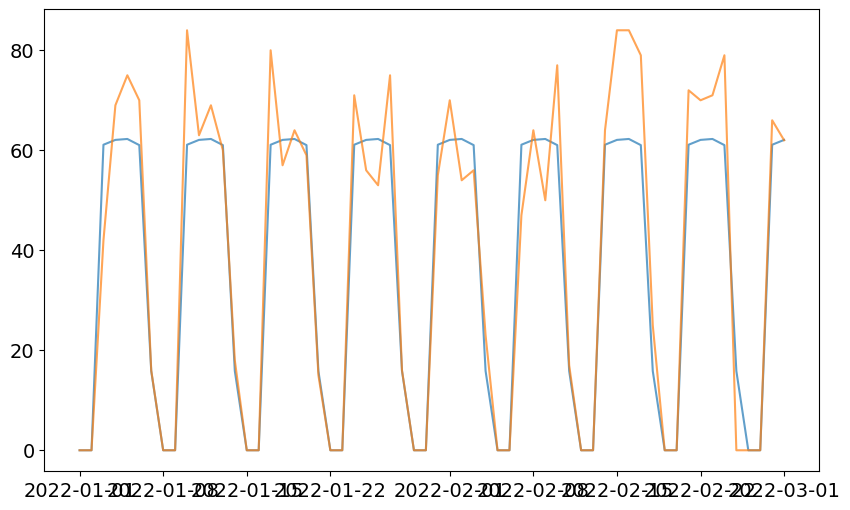

85.2663473774585

In [197]:
def method1(train: pd.DataFrame, test: pd.DataFrame, plot_pred=True):
  def day_of_week_means(df):
    weekdays = {}
    for i in range(7):
      weekdays[i] = df[df.index.weekday == i]['inspections'].mean()
      if np.isnan(weekdays[i]):
        weekdays[i] = 0
    return weekdays

  means = day_of_week_means(timeseries)

  # predict
  # index = []
  pred_raw = []
  weekday = train.index[-1].weekday() + 1 # first weekday of prediction
  # day = train.index[-1]
  while len(pred_raw) < test.shape[0]:
    # index.append()
    pred_raw.append(means[weekday])
    weekday += 1
    weekday %= 7

  pred = pd.DataFrame({"inspections": pred_raw, "date": test.index})
  pred = pred.set_index('date')

  err = mean_squared_error(test['inspections'], pred['inspections'])

  if plot_pred:
    plt.plot(pred, alpha=0.7)
    plt.plot(test, alpha=0.7)
    plt.show()

  return pred, err

pred, err = method1(train, test)
err

Predikce (modrá) nepřekvapivě podchycuje týdenní sezónnost.
Odhady nevypadají neuvěřitelně, pátky dokonce zdá se sedí velmi dobře.

Chybu získáme jako MSE, dává smysl penalizovat větší odchylky nelineárně více.

### Primitivní metoda - průměr "téhož" dne napříč lety
Pro jednoduchost implementace rozdělíme trénovací data na "roky" po 52 týdnech.
Na 4 letech, které máme k dispozici, se chyba neprojeví (maximálně vzhledem ke svátkům, ale tomu se stejně nedá zejm. v případě pohyblivých svátků předejít).

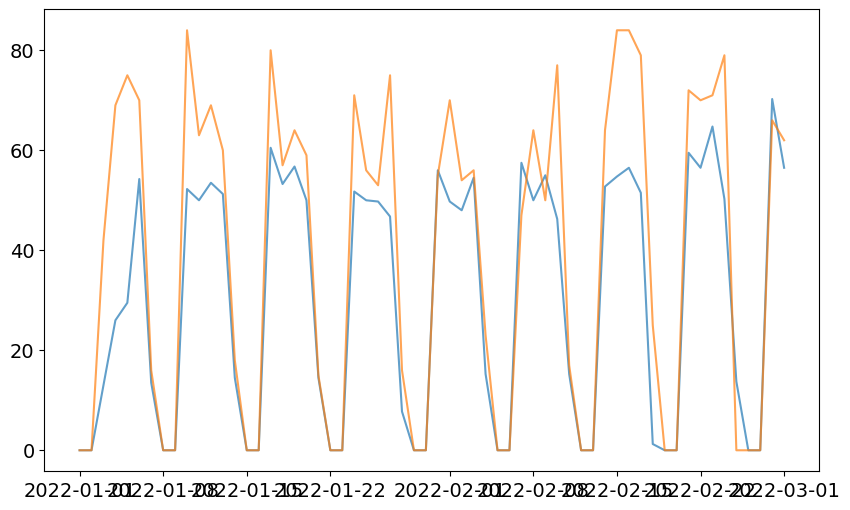

243.69166666666666

In [207]:
def method2(train: pd.DataFrame, test: pd.DataFrame, plot_pred=True, train_test_year_cutoff=True):
  if train_test_year_cutoff:
    train_years = range(train.index.min().year, train.index.max().year + 1)
  else:
    train_years = range(train.index.min().year, train.index.max().year)
  pred_raw = []
  for day in test.index:
    day_values = []
    cur_weekday = day.isoweekday()
    
    for year in train_years:
      # get nearest following same weekday
      dayloc = train.index.get_loc(f'{year}-{day.month:02}-{day.day:02}')
      dayloc += cur_weekday - (datetime.date(year, day.month, day.day).isoweekday())
      day_values.append(train.iloc[dayloc])
    
    pred_raw.append(np.array(day_values).mean())
  
  pred = pd.DataFrame({"inspections": pred_raw, "date": test.index})
  pred = pred.set_index('date')

  err = mean_squared_error(test['inspections'], pred['inspections'])

  if plot_pred:
    plt.plot(pred, alpha=0.7)
  plt.plot(test, alpha=0.7)
  plt.show()

  return pred, err

pred, err = method2(train, test)
err

Výsledky vypadají "zajímavěji", ale jejich MSE je zhruba trojnásobné ve srovnání s obyčejným průměrem v minulém modelu.
Je možné, že tento přístup trpí vlivem "podivných" let 2020 a 2021, které průměr sráží.
Tento model by ale mohl lépe předpovídat z dlouhodobého hlediska, např. na celý rok, protože lépe zachytí kolísající trend v datech.
Výsledky by tedy mohly vypadat o něco lépe v měsících, které se napříč lety tolik neměnily.

### Jednoduchá týdenní SARIMA
Nejprve analyzujeme autokorelační grafy.

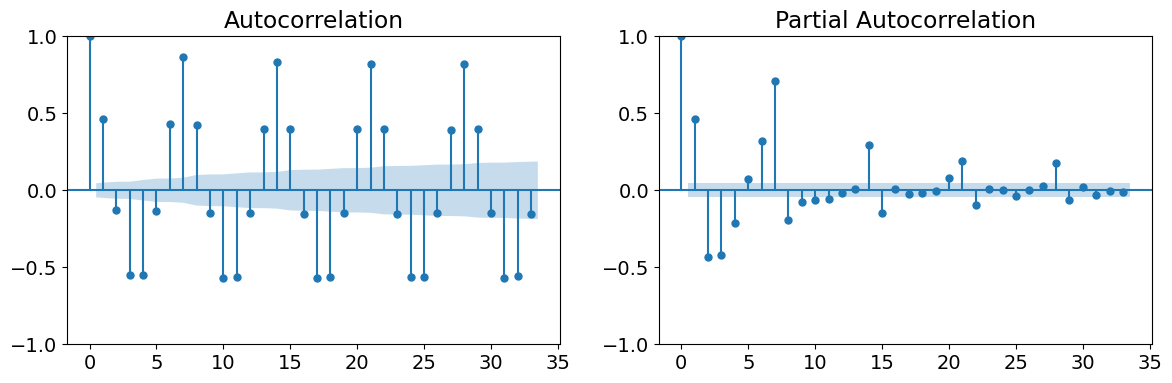

In [146]:
# fig = plt.figure(figsize=(14, 4))
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(14)
fig.set_figheight(4)
sm.graphics.tsa.plot_acf(timeseries['inspections'], ax=axs[0])
sm.graphics.tsa.plot_pacf(timeseries['inspections'], alpha=.05, ax=axs[1])
plt.show()

Z grafů (parciální) autokorelace proces sledujeme zcela jasně periodu 7.
Vzhledem k velmi pomalu klesající každé 7. hodnotě v grafu ACF bychom se mohli přiklonit zhruba k AR(2) procesu s periodou 7, PACF klesá poměrně rychle, i když dokonalá charakteristika AR procesu toto není.
Lze tedy očekávat, že proces by mohl být smíšený.

Zkusme ověřit stacionaritu, abychom vyloučili vhodnost diferencování.

In [151]:
result = sm.tsa.stattools.adfuller(timeseries['inspections'], autolag='AIC')
alpha = 0.05
print({
  'stationary': True if result[1] < alpha else False,
  'statistic': result[0],
  'pvalue': result[1],
  'alpha': alpha,
  'lag': result[2],
  'nobs': result[3],
  'autolag': 'AIC'
})

{'stationary': True, 'statistic': -5.384622384256841, 'pvalue': 3.648427583226898e-06, 'alpha': 0.05, 'lag': 21, 'nobs': 1772, 'autolag': 'AIC'}


S velmi nízkou p-hodnotou ADF testu můžeme směle zamítnout hypotézu přítomnosti jednotkového kořenu a prohlásit, že časová řada nejspíš je (slabě) stacionární.
Vzhledem ke stejnému charakteru časových řad napříč všemi STK lze přepokládat, že i ostatní časové řady budou stacionární.

Najdeme nyní vhodné parametry pro `ARMA(x, x)7`, modely budeme hodnotit pomocí AIC.

Hledat budeme pro 0-2 AR a MA parametry v základní i sezónní části a vyzkoušíme konstatní a žádný trend (varianta trendu lineárně měnícího se s časem je v tomto případě nesmyslná).

In [173]:
param_grid = ParameterGrid({
    'ar_seq': [0, 1, 2],
    'ma_seq': [0, 1, 2],
    'ar_season': [0, 1, 2],
    'ma_season': [0, 1, 2],
    'trend': ['n', 'c']
})
errors = []

def sarma(train, ar_seq, ma_seq, ar_season, ma_season, trend):
    data = np.array(train['inspections']).astype(np.float32)

    model = sm.tsa.SARIMAX(data, order=(ar_seq, 0, ma_seq), seasonal_order=(ar_season, 0, ma_season, 7), trend=trend)
    fit = model.fit(disp=False)
    return fit.aic

for i, params in enumerate(param_grid):
    if i != 141: # LinAlg error during convergence
      print(f'{i}: {params}')
      aic = sarma(train,
                  ar_seq=params['ar_seq'],
                  ma_seq=params['ma_seq'],
                  ar_season=params['ar_season'],
                  ma_season=params['ma_season'],
                  trend=params['trend'])
      errors.append(aic)

# get the parameters resulting in the lowest AIC
min_error_arma = 10000000
best_params_model = None
for i in range(0, len(errors) - 1):
    if errors[i] < min_error_arma:
        min_error_arma = errors[i]
        best_params_model = param_grid[i]

print(best_params_model)

142: {'ar_season': 2, 'ar_seq': 1, 'ma_season': 2, 'ma_seq': 2, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


143: {'ar_season': 2, 'ar_seq': 1, 'ma_season': 2, 'ma_seq': 2, 'trend': 'c'}
144: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 0, 'trend': 'n'}
145: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 0, 'trend': 'c'}
146: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 1, 'trend': 'n'}
147: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 1, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


148: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 2, 'trend': 'n'}
149: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 0, 'ma_seq': 2, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 0, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


151: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 0, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


152: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 1, 'trend': 'n'}
153: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 1, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


154: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 2, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


155: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 1, 'ma_seq': 2, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


156: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 0, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


157: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 0, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


158: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 1, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


159: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 1, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


160: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 2, 'trend': 'n'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


161: {'ar_season': 2, 'ar_seq': 2, 'ma_season': 2, 'ma_seq': 2, 'trend': 'c'}


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'trend': 'n', 'ma_seq': 2, 'ma_season': 1, 'ar_seq': 1, 'ar_season': 2}


Za povšimnutí stojí mnoho varování o nepodařené konvergenci iterační metody, možná by pomohl vyšší počet iterací či jiný optimizátor.
Prozkoumejme ale nalezený nejlepší model.

/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1461
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -5800.975
Date:                             Sun, 17 Dec 2023   AIC                          11615.951
Time:                                     20:58:46   BIC                          11652.959
Sample:                                          0   HQIC                         11629.756
                                            - 1461                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9661      0.014     68.551      0.000       0.938       0.994
ma.L1         -0.6099      

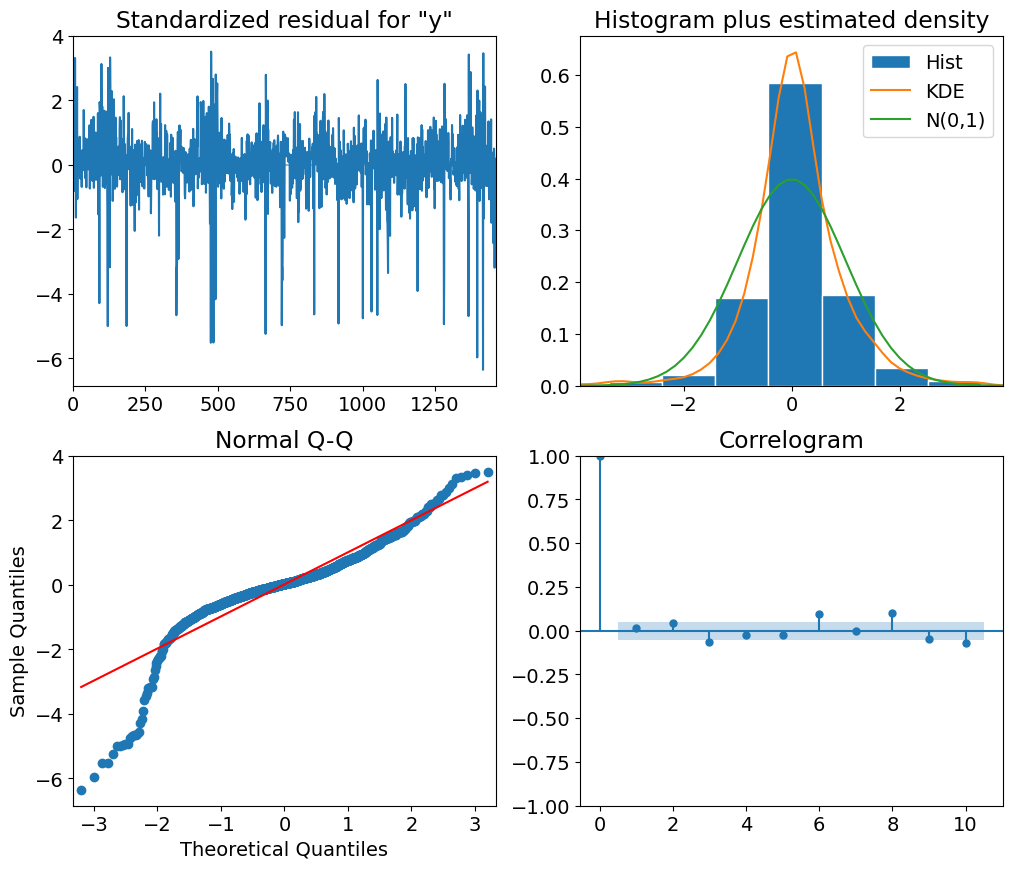

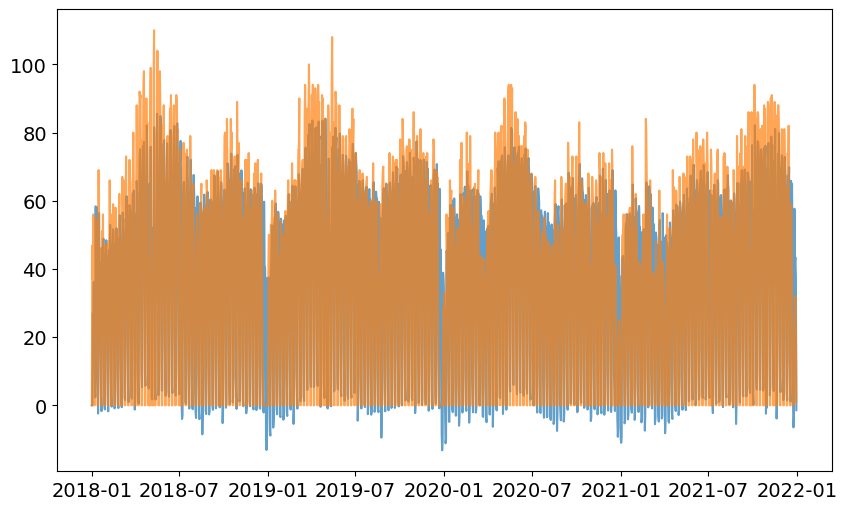

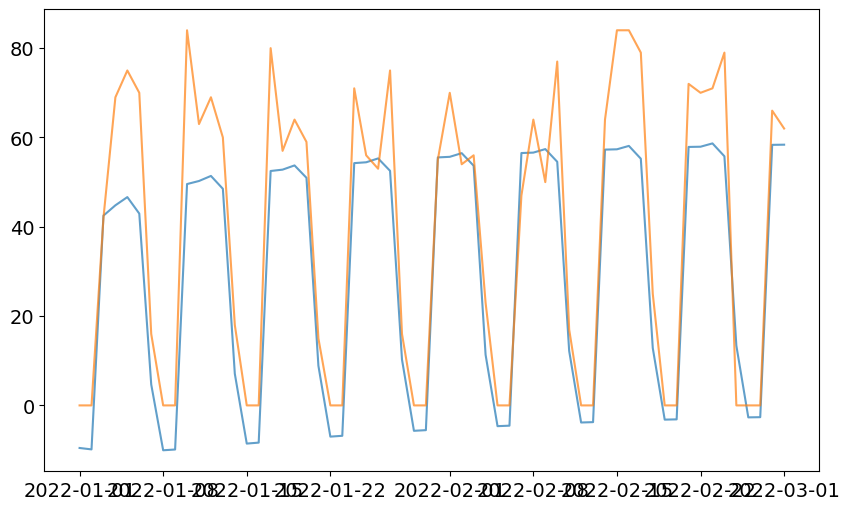

187.72812991771727


In [221]:
def method3(train: pd.DataFrame, test: pd.DataFrame, summary=False, plot_train=False, plot_pred=True, season=7):
  data = np.array(train['inspections']).astype(np.float32)
  model = sm.tsa.SARIMAX(data, order=(1, 0, 2), seasonal_order=(2, 0, 1, season), trend='n')
  fit = model.fit(disp=False)

  if summary:
    print(fit.summary())

    fit.plot_diagnostics(figsize=(12,10))
    plt.show()

  mod = fit.predict() #, dynamic=False)
  pred = fit.predict(len(train), len(test) + len(train) - 1) #, dynamic=False)

  mod = pd.DataFrame({"inspections": mod, "date": train.index})
  mod = mod.set_index('date')
  pred = pd.DataFrame({"inspections": pred, "date": test.index})
  pred = pred.set_index('date')

  if plot_train:
    plt.plot(mod, alpha=0.7)
    plt.plot(train, alpha=0.7)
    plt.show()

  if plot_pred:
    plt.plot(pred, alpha=0.7)
    plt.plot(test, alpha=0.7)
    plt.show()

  mse = mean_squared_error(test, pred)
  return pred, mse

pred, mse = method3(train, test, summary=True, plot_train=True)
print(mse)

Dobrým znamením jsou p-hodnoty testů hypotéz o nulovosti koeficientů a jejich konfidenční intervaly.
Všechny testy zamítáme, což napovídá, že parametry jsou v modelu užitečné a není jich příliš mnoho.

Rezidua vypadají taktéž rozumně, zejména korelogram s téměř všemi nenulovými lagy uvnitř konfidenčního intervalu napovídá, že model vysvětluje dostatečné množství informace.

Aplikace modelu na trénovací data ukazuje, že model často nedosáhne skutečného maxima, jinak se ale dat "chytá" poměrně obstojně.
Horší je častá predikce záporných hodnot, což vzhledem k významu dat (počet prohlídek vozidel) nedává smysl.

Jak se ale ukazuje z predikce testovacího intervalu, tyto záporné predikce nastávají pouze o víkendech, takže by bylo možné provést jednoduchou korekci oříznutím dat zespoda na nulu.
Predikce se vizuálně jeví jako poměrně smysluplná, její MSE je mezi obou předchozími metodami.

### Predikce jiného intervalu
Pro zajímavost zkusme predikovat jiný interval než začátek roku, kde zpravidla dochází k obratu v trendu.
Je možné, že v takovém případě bude SARIMA lepší.

In [222]:
train = timeseries['2018-01-01':'2022-03-31']
test = timeseries['2022-04-01':'2022-05-31']

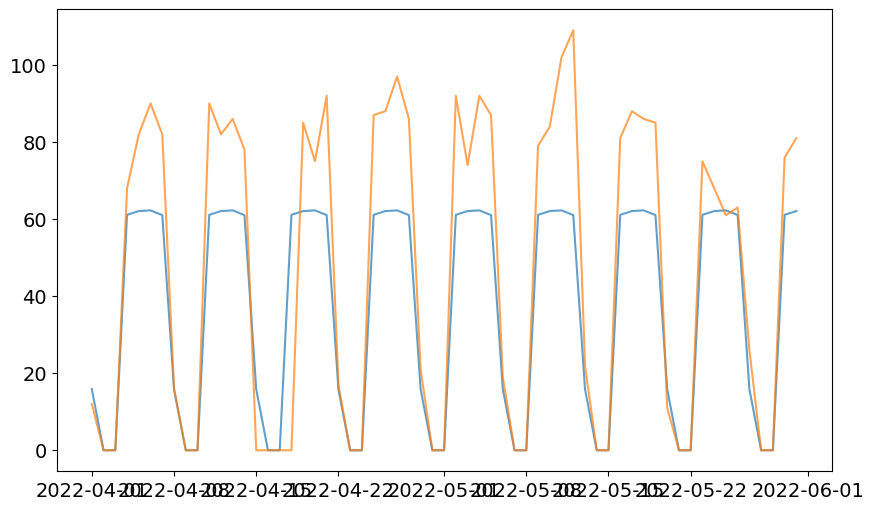

378.90332771215424


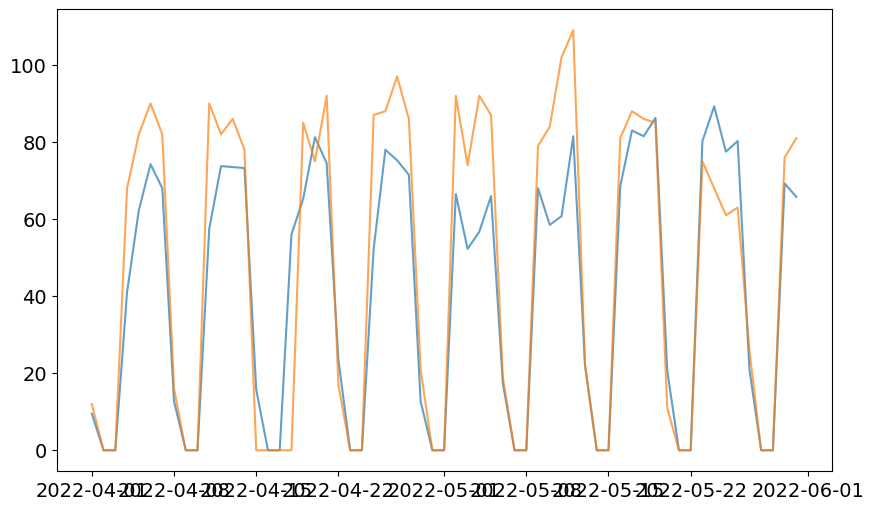

275.280737704918


/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


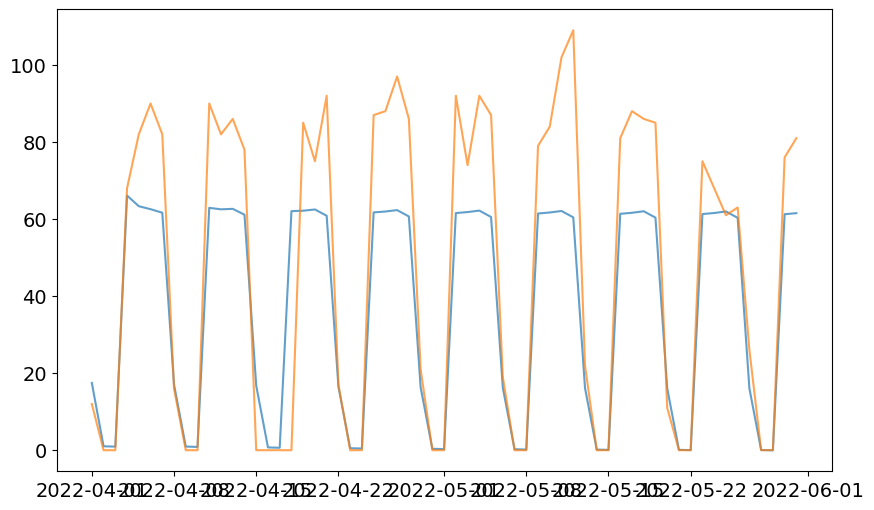

379.3991342660226


In [212]:
print(method1(train, test)[1])
print(method2(train, test, train_test_year_cutoff=False)[1])
print(method3(train, test)[1])

Z hlediska MSE je nyní SARIMA hodnocena podobně jako základní průměr.
Pokud by se ale podařilo vyřešit systematicky nižší predikované hodnoty, SARIMA by mohla dominovat.

### SARIMA pouze na pracovních dnech
Je možné, že systematická predikce nižších hodnot je způsobená přítomnými víkendy, které mohou ovlivňovat nesezónní část modelu a kazit tak předpovědi.
Zkusime pro zajímavost víkendy odebrat a použít stejný model, jen se sezónou délky 5, jestli se nezlepší jeho vlastnosti.

In [223]:
train = train[train.index.dayofweek < 5]
test = test[test.index.dayofweek < 5]

/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1109
Model:             SARIMAX(1, 0, 2)x(2, 0, [1], 5)   Log Likelihood               -4544.735
Date:                             Sun, 17 Dec 2023   AIC                           9103.470
Time:                                     20:59:08   BIC                           9138.549
Sample:                                          0   HQIC                          9116.736
                                            - 1109                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9073      0.026     34.246      0.000       0.855       0.959
ma.L1         -0.5443      

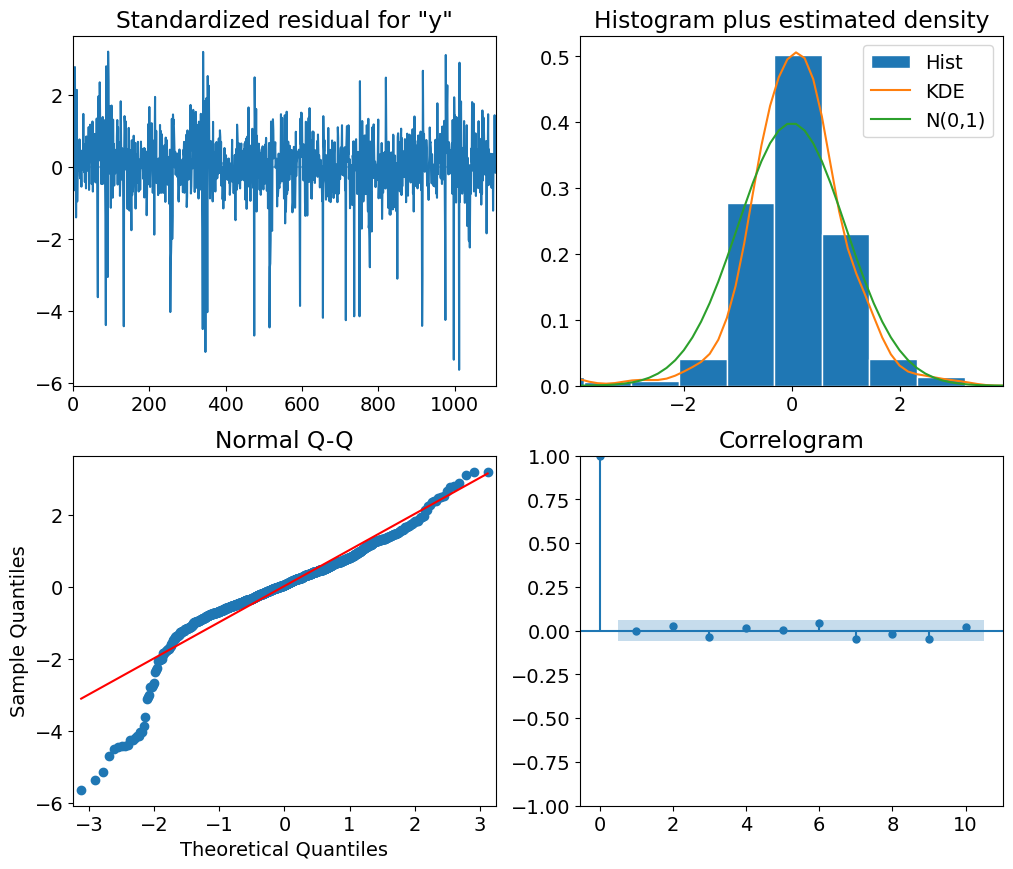

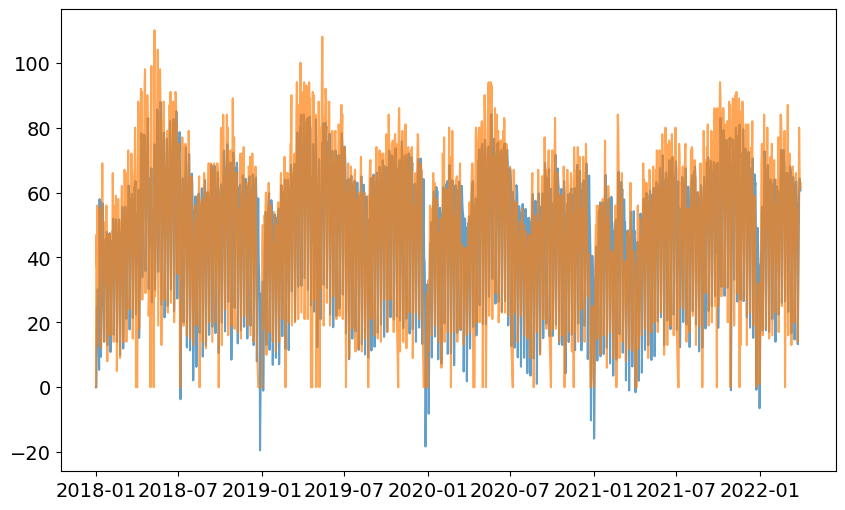

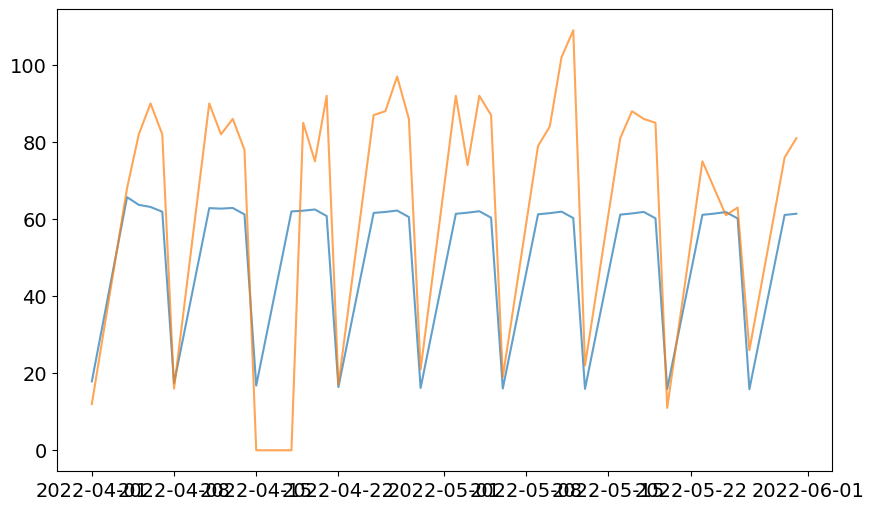

In [224]:
pred, err = method3(train, test, summary=True, plot_train=True, season=5)

Rezidua mají nyní ve srovnání N(0, 1) s jádrovým odhadem charakter o něco podobnější normálnímu rozdělení.
Autokorelace reziduí vypadá také o něco lépe.
Vidíme chybu predikce na Velikonoční pondělí.
Model stále ale predikuje systematicky o něco nižší hodnoty.

## Závěr
Při zkoumání dvou metod průměrování dat a použití modelu typu SARIMA byla zjištěna dominance modelu průměru na základě nejbližších stejných dní v týdnu v minulých letech.
Hlavním problémem SARIMA bylo systematické předpovídání nižších hodnot než skutečných.
Je možné, že pátky, které tradičně znamenají mnohem menší návštěvnost (stanice má ten den otevřeno pouze dopoledne) se vlivem nesezónní části modelu projevují ve zbytku týdne a snižují tak celkovou predikovanou hodnotu.

Získané předpovědi nejsou příliš kvalitní co se týče absolutních čísel, nicméně dobře podchycují zkrácenou pateční provozní dobu, tedy nejsou ani zdaleka nesmyslné.
Jelikož denní výkyvy v počtu prohlídek by bylo velmi obtížné či spíše nemožné předpovídat, výsledky nejspíš bude vhodnější použít pro historickou analýzu návštěvnosti.
Bylo by přitom ke zvážení použití některého z modelů časových řad k vyhlazování.